In [ ]:
from google.colab import drive # Uncomment first time running notebook
drive.mount('/content/drive') # Uncomment first time running notebook
!ls "/content/drive/Shareddrives/Advanced ML Project Spring 2021"

Mounted at /content/drive
 01b_cnn_offline.ipynb			   naive_bayes.ipynb
'2 - Upgraded Sentiment Analysis.ipynb'   'Nathan Lit Review.gdoc'
 charlie_midterm_presentation_backup.mp4   notebooks
'Data sources.gdoc'			  'Project To-Do List.gdoc'
'Final presentation.gslides'		  'Proposal ideas.gdoc'
'Final report.gdoc'			  'Proposal (Rough Draft).gdoc'
 intermediate_data			   raw_data
 LSTM.ipynb				   RNN.ipynb
'Mid-quarter presentation.gslides'	   scraped_data
 naive_bayes_final.ipynb


Thanks to Ben Trevett for his tutorial on using LSTMs for text classification. https://github.com/bentrevett/pytorch-sentiment-analysis

In [ ]:
import os
import urllib.request, json
import numpy as np
import pandas as pd
import torch

SHARED_DRIVE_BASE_FOLDER = "/content/drive/Shareddrives/Advanced ML Project Spring 2021/"
LABEL_VAR = 'partyWinning' # 'caseDisposition'
TEXT_VAR = 'text'
# BATCH_SIZE = 64 # batch size for training
BATCH_SIZE = 8 # batch size for training
MAX_VOCAB_SIZE = 5_000

# with open(SHARED_DRIVE_BASE_FOLDER + "intermediate_data/tuples_2017-2018.json") as fp:
#   tuple_list_2017_2018_data = json.load(fp)
# len(tuple_list_2017_2018_data)

In [ ]:
import warnings   # being significantly revamped
import random
import numpy as np
import torch
import torchtext as tt
from torchtext.legacy import data

# device = T.device("cpu")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [ ]:
!ls "/content/drive/Shareddrives/Advanced ML Project Spring 2021/"

 01b_cnn_offline.ipynb			  'Mid-quarter presentation.gslides'
'1 - Simple Sentiment Analysis.ipynb'	   naive_bayes.ipynb
'2 - Upgraded Sentiment Analysis.ipynb'   'Nathan Lit Review.gdoc'
 charlie_midterm_presentation_backup.mp4   notebooks
'Data sources.gdoc'			  'Project To-Do List.gdoc'
'Final presentation.gslides'		  'Proposal ideas.gdoc'
'Final report.gdoc'			  'Proposal (Rough Draft).gdoc'
 intermediate_data			   raw_data
 LSTM.ipynb				   scraped_data


Here, we read the data and tokenize using NLTK's English language stop words.

In [ ]:
warnings.filterwarnings("ignore")  # else warnings spew
random.seed(2)
torch.manual_seed(1)
np.random.seed(1)

from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
STOPWORDS = set(stopwords.words("english"))

def tokenize(s):
    tokens = [word for word in s.split(" ") if word not in STOPWORDS]
    return tokens

# RAW = data.RawField()
# TEXT = data.Field(tokenize = tokenize, 
#                   tokenizer_language = 'en_core_web_sm',
#                   batch_first = True)
# LABEL = data.LabelField(dtype = torch.float)

print("\nBegin torchtext from raw data demo ")

print("\nCreating RAW, TEXT, LABEL Field objects ")
# RAW = tt.data.RawField()
RAW = data.RawField()
# TEXT = tt.data.Field(sequential=True,
TEXT = data.Field(sequential=True,
  init_token='',  # start of sequence
  eos_token='',   # end of sequence
  lower=True,
  tokenize=tokenize,
  include_lengths=True)
# LABEL = tt.data.Field(sequential=False,
LABEL = data.Field(sequential=False,
  use_vocab=False,
  unk_token=None,
  is_target=True,
  dtype=torch.float)

print("\nSplitting into train, valid, test ")
(train_obj, valid_obj, test_obj) = \
  data.TabularDataset.splits(
  # tt.data.TabularDataset.splits(
  path=".\\.data",
  # train='train.csv',
  train=SHARED_DRIVE_BASE_FOLDER + f"intermediate_data/train_balanced_2001-2019.csv",
  # validation='validation.csv',
  validation=SHARED_DRIVE_BASE_FOLDER + f"intermediate_data/validate_balanced_2001-2019.csv",
  # test='test.csv',
  test=SHARED_DRIVE_BASE_FOLDER + f"intermediate_data/test_balanced_2001-2019.csv",
  format='csv',
  skip_header=True,
  # fields=[('id', RAW), ('review', TEXT),
  #   ('label', LABEL)])
  fields=[('id', RAW), ('label', LABEL), ('text', TEXT)])

print("\nThe \'text\' field for item [2] is: ")
print(train_obj[2].text)

print("\nCreating vocabulary object ") # Using pre-trained word embeddings
TEXT.build_vocab(train_obj, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)
print("The idx of \'good\' is ",
  TEXT.vocab.stoi['good'])  # 13
print("The string value of 8 is ",
  TEXT.vocab.itos[8])  # 'bad'

LABEL.build_vocab(train_obj)
print("LABEL.vocab.stoi is " + str(LABEL.vocab.stoi))
 
print("\nCreating a train BucketIterator ")

# train_iter  = tt.data.BucketIterator(
train_iter = data.BucketIterator(
  dataset=train_obj,
  batch_size = 8,
  sort_key=lambda x: len(x.text),
  sort_within_batch=True,
  shuffle=True,
  device=device)

valid_iter = data.BucketIterator(
  dataset=valid_obj,
  batch_size = 8,
  sort_key=lambda x: len(x.text),
  sort_within_batch=True,
  device=device)

test_iter = data.BucketIterator(
  dataset=test_obj,
  batch_size = 8,
  sort_key=lambda x: len(x.text),
  sort_within_batch=True,
  device=device)
# print("train_obj")
# print(train_obj)
# print(next(train_obj))

print("\nIterating train data (batch_size=2) ")
# for item in iter(train_iter):
for item in train_iter:
  print("\n=====\n")
  print(item.id)
  print(item.text)
  print(item.label)
  
print("\nEnd of demo ")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.

Begin torchtext from raw data demo 

Creating RAW, TEXT, LABEL Field objects 

Splitting into train, valid, test 

The 'text' field for item [2] is: 
['', 'hear', 'argument', 'exxon', 'mobil', 'saudi', 'basic', 'industries', 'mr', 'coleman', 'trust', 'soon', 'tell', 'us', 'case', 'moot', 'whether', 'think', 'moot', 'good', 'morning', 'justice', 'stevens', 'may', 'please', 'court', 'begin', 'would', 'like', 'case', 'moot', 'ongoing', 'case', 'controversy', 'parties', 'judgment', 'true', 'delaware', 'state', 'court', 'affirmed', 'delaware', 'supreme', 'court', 'preclusion', 'doctrines', 'rookerfeldman', 'mootness', 'govern', 'resolution', 'claims', 'asserted', 'first', 'well', 'financial', 'interests', 'clients', 'keep', 'litigating', 'today', 'another', 'court', 'dont', 'know', 'whats', 'going', 'mean', 'confusing', 'well', 'certainly', 'justice', 'oconnor', 'weve', 'yet', 're

.vector_cache/glove.6B.zip: 862MB [02:41, 5.35MB/s]                           
100%|█████████▉| 398951/400000 [00:14<00:00, 28042.32it/s]

The idx of 'good' is  167
The string value of 8 is  well
LABEL.vocab.stoi is defaultdict(None, {'1.0': 0, '0.0': 1, '2.0': 2})

Creating a train BucketIterator 

Iterating train data (batch_size=2) 

=====

['83', '158', '139', '139', '535', '31', '626', '171']
(tensor([[  2,   2,   2,  ...,   2,   2,   2],
        [  2,   2,   2,  ...,   2,   2,   2],
        [  8,   8,   8,  ...,   8,   8,   8],
        ...,
        [  6,   1,   1,  ...,   1,   1,   1],
        [571,   1,   1,  ...,   1,   1,   1],
        [  2,   1,   1,  ...,   1,   1,   1]], device='cuda:0'), tensor([3580, 3531, 3528, 3528, 3506, 3376, 3319, 3300], device='cuda:0'))
tensor([0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')

=====

['329', '519', '631', '585', '875', '643', '138', '1106']
(tensor([[  2,   2,   2,  ...,   2,   2,   2],
        [  2,   2,   2,  ...,   2,   2,   2],
        [  8, 380,   8,  ...,   8,   8,   8],
        ...,
        [  6,   1,   1,  ...,   1,   1,   1],
        [571,   1,   1,  ...,   

In [ ]:
# train = pd.read_csv(SHARED_DRIVE_BASE_FOLDER + f"intermediate_data/train_balanced_2010-2018.csv")
# validate = pd.read_csv(SHARED_DRIVE_BASE_FOLDER + f"intermediate_data/validate_balanced_2010-2018.csv")
# test = pd.read_csv(SHARED_DRIVE_BASE_FOLDER + f"intermediate_data/test_balanced_2010-2018.csv")
# print("Balanced Dataset???:")
# print(train['partyWinning'].value_counts())
# print(validate['partyWinning'].value_counts())
# print(test['partyWinning'].value_counts())

# train = pd.read_csv(SHARED_DRIVE_BASE_FOLDER + f"intermediate_data/train_2010-2018.csv")
# validate = pd.read_csv(SHARED_DRIVE_BASE_FOLDER + f"intermediate_data/validate_2010-2018.csv")
# test = pd.read_csv(SHARED_DRIVE_BASE_FOLDER + f"intermediate_data/test_2010-2018.csv")
# print("Original Dataset:")
# print(train['partyWinning'].value_counts())
# print(validate['partyWinning'].value_counts())
# print(test['partyWinning'].value_counts())

In [ ]:
import torch
from torchtext.legacy import data

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        # print("Embedding layer:")
        # print(embedded)
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        # lengths need to be on CPU!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        # print("packed sequence:")
        # print(packed_embedded)
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        # print("packed output:")
        # print(packed_output)
        # print("hidden layer:")
        # print((hidden, cell))
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        # print("output and output lengths:")
        # print(output, output_lengths)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        # print("hidden:")
        # print(hidden)
                
        #hidden = [batch size, hid dim * num directions]
        # print("final output:")
        # print(self.fc(hidden))
            
        return self.fc(hidden)

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 1
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,233,997 trainable parameters


The final addition is copying the pre-trained word embeddings we loaded earlier into the `embedding` layer of our model.

We retrieve the embeddings from the field's vocab, and check they're the correct size, _**[vocab size, embedding dim]**_ 

In [ ]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([5003, 100])


In [ ]:
TEXT.vocab.vectors

tensor([[-1.5256, -0.7502, -0.6540,  ...,  0.3434, -1.0703, -0.8743],
        [ 0.2053,  0.3051,  0.5357,  ..., -0.4203,  0.2828,  0.3642],
        [ 2.6415, -0.9624, -0.2076,  ...,  0.4667,  1.2831,  1.2678],
        ...,
        [-0.1198,  0.0747, -0.0700,  ..., -0.2026,  0.2033,  0.0977],
        [ 0.0717, -0.2130, -0.5615,  ..., -0.0854, -0.0518,  0.3673],
        [ 0.4921,  0.4126,  0.8025,  ..., -0.8304,  0.4134, -0.5876]])

In [ ]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-1.5256, -0.7502, -0.6540,  ...,  0.3434, -1.0703, -0.8743],
        [ 0.2053,  0.3051,  0.5357,  ..., -0.4203,  0.2828,  0.3642],
        [ 2.6415, -0.9624, -0.2076,  ...,  0.4667,  1.2831,  1.2678],
        ...,
        [-0.1198,  0.0747, -0.0700,  ..., -0.2026,  0.2033,  0.0977],
        [ 0.0717, -0.2130, -0.5615,  ..., -0.0854, -0.0518,  0.3673],
        [ 0.4921,  0.4126,  0.8025,  ..., -0.8304,  0.4134, -0.5876]])

In [ ]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 2.6415, -0.9624, -0.2076,  ...,  0.4667,  1.2831,  1.2678],
        ...,
        [-0.1198,  0.0747, -0.0700,  ..., -0.2026,  0.2033,  0.0977],
        [ 0.0717, -0.2130, -0.5615,  ..., -0.0854, -0.0518,  0.3673],
        [ 0.4921,  0.4126,  0.8025,  ..., -0.8304,  0.4134, -0.5876]])


## Train the Model

In [ ]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

We implement the function to calculate accuracy...

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.tanh(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion):
    '''
    Train the model by iterating through batches.
    '''
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        # print("batch.text is")
        # print(batch.text)
        
        text, text_lengths = batch.text
        
        predictions = model(text, text_lengths).squeeze(1)
        # print("predictions:")
        # print(predictions)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

And also create a nice function to tell us how long our epochs are taking.

In [ ]:
import time

def epoch_time(start_time, end_time):
    '''
    Calculates time elapsed per epoch.
    '''
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we train our model...

This is a bidirectional one-layer model with 50% dropout trained with an Adam optimizer.

In [ ]:
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iter, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iter, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model' + '_epoch' + str(model.parameters()) + '.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 2m 54s
	Train Loss: 0.695 | Train Acc: 50.37%
	 Val. Loss: 0.692 |  Val. Acc: 50.00%
Epoch: 02 | Epoch Time: 2m 54s
	Train Loss: 0.695 | Train Acc: 49.91%
	 Val. Loss: 0.692 |  Val. Acc: 49.70%
Epoch: 03 | Epoch Time: 2m 54s
	Train Loss: 0.695 | Train Acc: 48.88%
	 Val. Loss: 0.692 |  Val. Acc: 50.00%
Epoch: 04 | Epoch Time: 2m 55s
	Train Loss: 0.694 | Train Acc: 50.84%
	 Val. Loss: 0.693 |  Val. Acc: 48.81%
Epoch: 05 | Epoch Time: 2m 55s
	Train Loss: 0.694 | Train Acc: 50.56%
	 Val. Loss: 0.692 |  Val. Acc: 49.11%


In [ ]:
model.load_state_dict(torch.load('tut2-model.pt'))

test_loss, test_acc = evaluate(model, test_iter, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.694 | Test Acc: 48.84%


In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = False
DROPOUT = 0.25
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

model.embedding.weight.data.copy_(pretrained_embeddings)

UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 2.6415, -0.9624, -0.2076,  ...,  0.4667,  1.2831,  1.2678],
        ...,
        [-0.1198,  0.0747, -0.0700,  ..., -0.2026,  0.2033,  0.0977],
        [ 0.0717, -0.2130, -0.5615,  ..., -0.0854, -0.0518,  0.3673],
        [ 0.4921,  0.4126,  0.8025,  ..., -0.8304,  0.4134, -0.5876]])


Next, we train a two-layer, non-bidirectional model. We also reduce the dropout to 0.25 from 0.5.

In [ ]:
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iter, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iter, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 3m 41s
	Train Loss: 0.694 | Train Acc: 50.19%
	 Val. Loss: 0.692 |  Val. Acc: 49.70%
Epoch: 02 | Epoch Time: 3m 40s
	Train Loss: 0.693 | Train Acc: 49.63%
	 Val. Loss: 0.693 |  Val. Acc: 49.40%
Epoch: 03 | Epoch Time: 3m 41s
	Train Loss: 0.689 | Train Acc: 54.57%
	 Val. Loss: 0.694 |  Val. Acc: 49.11%
Epoch: 04 | Epoch Time: 3m 41s
	Train Loss: 0.683 | Train Acc: 55.69%
	 Val. Loss: 0.699 |  Val. Acc: 51.49%
Epoch: 05 | Epoch Time: 3m 41s
	Train Loss: 0.676 | Train Acc: 56.34%
	 Val. Loss: 0.713 |  Val. Acc: 49.40%


In [ ]:
model.load_state_dict(torch.load('tut2-model.pt'))

test_loss, test_acc = evaluate(model, test_iter, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.694 | Test Acc: 48.84%


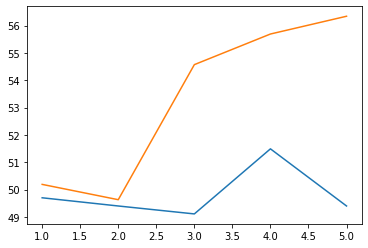

In [ ]:
import matplotlib.pyplot as plt

train_acc = [50.19, 49.63, 54.57, 55.69, 56.34]
valid_acc = [49.70, 49.40, 49.11, 51.49, 49.40]
epochs = [1, 2, 3, 4, 5]
plt.plot(epochs, valid_acc)
plt.plot(epochs, train_acc)

Next, we reduce the number of hidden dimensions but increase the number of layers. Dropout is 0.35.

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 150
OUTPUT_DIM = 1
N_LAYERS = 3
BIDIRECTIONAL = False
DROPOUT = 0.35
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 2.6415, -0.9624, -0.2076,  ...,  0.4667,  1.2831,  1.2678],
        ...,
        [-0.1198,  0.0747, -0.0700,  ..., -0.2026,  0.2033,  0.0977],
        [ 0.0717, -0.2130, -0.5615,  ..., -0.0854, -0.0518,  0.3673],
        [ 0.4921,  0.4126,  0.8025,  ..., -0.8304,  0.4134, -0.5876]])


In [ ]:
def binary_accuracy(preds, y):
    """
    THIS TIME WITH SIGMOID INSTEAD OF TANH.
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iter, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iter, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 6m 2s
	Train Loss: 0.694 | Train Acc: 49.53%
	 Val. Loss: 0.693 |  Val. Acc: 48.81%
Epoch: 02 | Epoch Time: 6m 1s
	Train Loss: 0.694 | Train Acc: 49.16%
	 Val. Loss: 0.693 |  Val. Acc: 49.70%
Epoch: 03 | Epoch Time: 6m 1s
	Train Loss: 0.693 | Train Acc: 49.63%
	 Val. Loss: 0.693 |  Val. Acc: 49.40%
Epoch: 04 | Epoch Time: 6m 1s
	Train Loss: 0.693 | Train Acc: 50.00%
	 Val. Loss: 0.693 |  Val. Acc: 50.00%
Epoch: 05 | Epoch Time: 6m 1s
	Train Loss: 0.692 | Train Acc: 52.33%
	 Val. Loss: 0.694 |  Val. Acc: 51.49%


In [ ]:
model.load_state_dict(torch.load('tut2-model.pt'))

test_loss, test_acc = evaluate(model, test_iter, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.694 | Test Acc: 49.13%


In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 150
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.3
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 2.6415, -0.9624, -0.2076,  ...,  0.4667,  1.2831,  1.2678],
        ...,
        [-0.1198,  0.0747, -0.0700,  ..., -0.2026,  0.2033,  0.0977],
        [ 0.0717, -0.2130, -0.5615,  ..., -0.0854, -0.0518,  0.3673],
        [ 0.4921,  0.4126,  0.8025,  ..., -0.8304,  0.4134, -0.5876]])


In [ ]:
def binary_accuracy(preds, y):
    """
    THIS TIME WITH SIGMOID INSTEAD OF TANH.
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.tanh(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iter, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iter, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 5m 35s
	Train Loss: 0.696 | Train Acc: 49.72%
	 Val. Loss: 0.692 |  Val. Acc: 49.11%
Epoch: 02 | Epoch Time: 5m 35s
	Train Loss: 0.695 | Train Acc: 49.72%
	 Val. Loss: 0.695 |  Val. Acc: 49.11%
Epoch: 03 | Epoch Time: 5m 35s
	Train Loss: 0.694 | Train Acc: 49.72%
	 Val. Loss: 0.693 |  Val. Acc: 49.11%
Epoch: 04 | Epoch Time: 5m 35s
	Train Loss: 0.694 | Train Acc: 49.72%
	 Val. Loss: 0.693 |  Val. Acc: 49.11%
Epoch: 05 | Epoch Time: 5m 35s
	Train Loss: 0.695 | Train Acc: 49.72%
	 Val. Loss: 0.693 |  Val. Acc: 49.11%


In [ ]:
model.load_state_dict(torch.load('tut2-model.pt'))

test_loss, test_acc = evaluate(model, test_iter, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.694 | Test Acc: 50.87%


Finally, we reload the data and try a larger vocabulary size of 10000.

In [ ]:
print("\nBegin torchtext from raw data demo ")

print("\nCreating RAW, TEXT, LABEL Field objects ")
# RAW = tt.data.RawField()
RAW = data.RawField()
# TEXT = tt.data.Field(sequential=True,
TEXT = data.Field(sequential=True,
  init_token='',  # start of sequence
  eos_token='',   # end of sequence
  lower=True,
  tokenize=tokenize,
  include_lengths=True)
# LABEL = tt.data.Field(sequential=False,
LABEL = data.Field(sequential=False,
  use_vocab=False,
  unk_token=None,
  is_target=True,
  dtype=torch.float)

print("\nSplitting into train, valid, test ")
(train_obj, valid_obj, test_obj) = \
  data.TabularDataset.splits(
  # tt.data.TabularDataset.splits(
  path=".\\.data",
  # train='train.csv',
  train=SHARED_DRIVE_BASE_FOLDER + f"intermediate_data/train_balanced_2001-2019.csv",
  # validation='validation.csv',
  validation=SHARED_DRIVE_BASE_FOLDER + f"intermediate_data/validate_balanced_2001-2019.csv",
  # test='test.csv',
  test=SHARED_DRIVE_BASE_FOLDER + f"intermediate_data/test_balanced_2001-2019.csv",
  format='csv',
  skip_header=True,
  # fields=[('id', RAW), ('review', TEXT),
  #   ('label', LABEL)])
  fields=[('id', RAW), ('label', LABEL), ('text', TEXT)])

print("\nThe \'text\' field for item [2] is: ")
print(train_obj[2].text)

print("\nCreating vocabulary object ") # Using pre-trained word embeddings
TEXT.build_vocab(train_obj, 
                 max_size = 10000, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)
print("The idx of \'good\' is ",
  TEXT.vocab.stoi['good'])  # 13
print("The string value of 8 is ",
  TEXT.vocab.itos[8])  # 'bad'

LABEL.build_vocab(train_obj)
print("LABEL.vocab.stoi is " + str(LABEL.vocab.stoi))
 
print("\nCreating a train BucketIterator ")

# train_iter  = tt.data.BucketIterator(
train_iter = data.BucketIterator(
  dataset=train_obj,
  batch_size = 8,
  sort_key=lambda x: len(x.text),
  sort_within_batch=True,
  shuffle=True,
  device=device)

valid_iter = data.BucketIterator(
  dataset=valid_obj,
  batch_size = 8,
  sort_key=lambda x: len(x.text),
  sort_within_batch=True,
  device=device)

test_iter = data.BucketIterator(
  dataset=test_obj,
  batch_size = 8,
  sort_key=lambda x: len(x.text),
  sort_within_batch=True,
  device=device)
# print("train_obj")
# print(train_obj)
# print(next(train_obj))

print("\nIterating train data (batch_size=2) ")
# for item in iter(train_iter):
for item in train_iter:
  print("\n=====\n")
  print(item.id)
  print(item.text)
  print(item.label)
  
print("\nEnd of demo ")


Begin torchtext from raw data demo 

Creating RAW, TEXT, LABEL Field objects 

Splitting into train, valid, test 

The 'text' field for item [2] is: 
['', 'hear', 'argument', 'exxon', 'mobil', 'saudi', 'basic', 'industries', 'mr', 'coleman', 'trust', 'soon', 'tell', 'us', 'case', 'moot', 'whether', 'think', 'moot', 'good', 'morning', 'justice', 'stevens', 'may', 'please', 'court', 'begin', 'would', 'like', 'case', 'moot', 'ongoing', 'case', 'controversy', 'parties', 'judgment', 'true', 'delaware', 'state', 'court', 'affirmed', 'delaware', 'supreme', 'court', 'preclusion', 'doctrines', 'rookerfeldman', 'mootness', 'govern', 'resolution', 'claims', 'asserted', 'first', 'well', 'financial', 'interests', 'clients', 'keep', 'litigating', 'today', 'another', 'court', 'dont', 'know', 'whats', 'going', 'mean', 'confusing', 'well', 'certainly', 'justice', 'oconnor', 'weve', 'yet', 'recovered', 'judgment', 'judgment', 'still', 'still', 'existence', 'weve', 'yet', 'collected', 'dont', 'believe',

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.3
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0754,  0.1221,  0.6161,  ..., -0.8002,  0.7457, -1.9731],
        ...,
        [-0.6750, -1.3385,  0.7660,  ..., -0.3718, -0.9194, -1.3551],
        [ 0.1279,  0.5914, -0.3891,  ...,  0.1257,  0.8320,  0.6803],
        [ 0.9505,  0.6647, -0.2140,  ...,  0.6387, -0.1089,  0.5823]])


In [ ]:
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iter, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iter, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

TypeError: ignored